In [1]:
### RETURNS MOMENTUM FACTORS DAILY GENERATOR

In [2]:
### INITIALIZATION

import pandas as pd
import numpy as np
import math
import gc
import os
from datetime import date, datetime
from sklearn.linear_model import LinearRegression ### For Residual Factor

In [3]:
### VERSION CONTROL

from platform import python_version
### Expected Python Version:  3.7.4
print('python version: ', python_version())
### Expected NumPy Version:  1.17.2
print('numpy version: ', np.__version__)
### Expected Pandas version:  0.25.3
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [4]:
### CONSTANTS INITIALIZATION

### Common constants:
All = slice(None)
### General daily-mode and ranges initialization:
str_date_factor_start = '2004-12-31' ### End date for efficacy measures
str_date_factor_end = '2023-04-28' ### End date for efficacy measures
idx_test_monthly_range = pd.date_range(str_date_factor_start, str_date_factor_end, freq = 'BM') ### Range for source data filtering
idx_test_daily_range = pd.date_range(str_date_factor_start, str_date_factor_end, freq = 'B') ### Range for source data filtering
### Results saving paths:
str_wa_basic_path = 'Data_Files/Test_Files/ret_mom_wa_basic.csv'
str_wa_ranks_path = 'Data_Files/Test_Files/ret_mom_wa_ranks.csv'
str_seas_q_path = 'Data_Files/Test_Files/ret_mom_seas_q.csv'
str_seas_y_3mo_path = 'Data_Files/Test_Files/ret_mom_seas_y_3mo.csv'
str_wa_residual_path = 'Data_Files/Test_Files/ret_mom_wa_residual.csv'
str_wa_dyn_lb_ind_path = 'Data_Files/Test_Files/ret_mom_wa_dyn_lb_ind.csv'
str_wa_dyn_lb_reg_path = 'Data_Files/Test_Files/ret_mom_wa_dyn_lb_reg.csv'

In [5]:
### DEFINING EXPONENTIAL WEIGHT

def exp_weight_single(halflife_len = 3, num_element = 0):
    ### Weight calculating:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = math.exp(math.log(num_period_factor) * num_element)
    ### Result output:
    return num_weight

In [6]:
### DEFINING WEIGHTED AVERAGE

def weighted_average(ser_data, ser_weight = None, int_min_count = 0, bool_normalize = True):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if (ser_weight is None):
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                if bool_normalize:
                    num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
                else:
                    num_result = np.nansum(list_data * list_weight)
    ### Results output:
    return num_result

In [7]:
### DEFINING AVERAGE OF RETURNS CALCULATION (TO IMPLEMENT ADDITIONAL CONTROL FILTERS)

def weighted_average_grouped(ser_country, ser_weight = None):
    ### Minimum number of observations:
    int_min_number = int(260 / 2)
    ### Last values control interval length:
    int_last_control = 10
    ### Implementing control filters and performing weighted average calulation:
    if ((ser_country.count() >= int_min_number) & (ser_country[-int_last_control : ].count() > 0)):
        flo_wa = weighted_average(ser_country.droplevel('Country'), ser_weight)
    else:
        flo_wa = np.NaN
    return flo_wa

In [8]:
### DEFINING MULTI-STEP STANDARTIZATION FOR SEPARATE SERIES

def multistep_standartize(ser_data_source, arr_truncate, ser_weight = False, reuse_outliers = False, center_result = True, full_result = False):  
    ### Arrays of iterations properties:
    arr_mean = []
    arr_std = []
    ### Adding equal weights, when weights are absent:
    if isinstance(ser_weight, bool):
        ser_weight = pd.Series(1, index = ser_data_source.index)
        ser_weight.name = 'Weight'    
    ### Workhorse and resulting data vectors initialising:
    ser_data_iter = ser_data_source.dropna()
    ser_weight_iter = ser_weight.copy()
    ser_data_full = pd.Series(np.NaN, index = ser_data_iter.index)
    ### Looping by boundaries array:
    for num_bound_iter in arr_truncate:
        ### Properties calculating and saving:
        num_mean_iter = weighted_average(ser_data_iter, ser_weight_iter)
        num_std_iter = ser_data_iter.std()
        arr_mean.append(num_mean_iter)
        arr_std.append(num_std_iter)
        ser_data_iter = (ser_data_iter - num_mean_iter) / num_std_iter       
        ### Standartizing:
        if reuse_outliers:
            ser_data_iter[ser_data_iter.abs() >= num_bound_iter] = np.sign(ser_data_iter) * num_bound_iter 
        else:
            ### Saving to result and excluding from further calculations truncated values:             
            ser_data_full.where(ser_data_iter.abs() < num_bound_iter, np.sign(ser_data_iter) * num_bound_iter, inplace = True)      
            ser_data_iter = ser_data_iter[ser_data_iter.abs() < num_bound_iter]           
    ### Aggregating result:
    if (reuse_outliers):
        ser_data_full = ser_data_iter
    else:     
        ser_data_full[ser_data_iter.index] = ser_data_iter
    ### Centering result:
    if (center_result):
        ser_result = ser_data_full - weighted_average(ser_data_full, ser_weight) 
    else:
        ser_result = ser_data_full    
    ### Result output:
    ser_result.name = str(ser_data_source.name) + '_standartized'
    if (full_result):
        return (ser_result, arr_mean, arr_std)
    else:
        return ser_result

In [9]:
### DEFINING STANDARTIZE -> RECOVER -> NEGATIVE RETURNS CLIP TRANSFORMATION

def get_country_vector(ser_source_raw, idx_source_range):
    ### Drop level to avoid stack/unstack manipulations:
    if (len(ser_source_raw.index.names) == 2):
        ser_source_raw = ser_source_raw.droplevel(-1)       
    ### Source vector cleaning:
    ser_source_raw = ser_source_raw.replace([np.inf, -np.inf], np.NaN).replace(0.0, np.NaN)
    ### Source vector standartizing:
    ser_source_std, list_mean, list_std = multistep_standartize(ser_source_raw, [7.5, 6.0], full_result = True)
    ### Source vector recovering:
    ser_source_rec = (ser_source_std * list_std[1] + list_mean[1]) * list_std[0] + list_mean[0]
    ### Negative values clipping:
    ser_source_rec.loc[ser_source_rec < -1.0] = -0.9
    ### Source vector to rates:
    ser_source_rate = (1 + ser_source_rec.fillna(0.0)).cumprod()
    ### Rates vector reindexing:
    ser_source_rate = ser_source_rate.reindex(idx_source_range)
    ### Rates vector forward filling:
    ser_source_rate = ser_source_rate.ffill()
    ### Rates vector to returns:
    ser_source_res = ser_source_rate.diff() / ser_source_rate.shift()
    ser_source_res = ser_source_res.replace(0.0, np.NaN)
    ### Result output:    
    ser_source_res.index.names = ['Date']
    ser_source_res.name = 'Returns'
    return ser_source_res

In [10]:
### TO REPLACE WITH SQL REQUEST: DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [11]:
### TO REPLACE WITH SQL REQUEST: REGIONAL INFO EXTRACTION

### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### ISON membership history in daily frequency:
ser_ison_membership_daily = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_factor_end), True, 60)
ser_ison_membership_daily.index.names = ['Date', 'Country']

In [12]:
### TO REPLACE WITH SQL REQUEST: RETURNS DATASETS LOADING

### Regions list to extract Market Returns from common file:
list_regions = ['DM', 'EM', 'FM']
### NA for MS Excel / CSV files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Sample data source:
str_path_returns = 'Data_Files/Source_Files/msci_sample.csv'
### Sample returns data loading:
df_sample_ret = pd.read_csv(str_path_returns, header = 0, parse_dates = None, index_col = None, na_values = list_na_excel_values, keep_default_na = False, sep = ';')
df_sample_ret['Date'] = pd.to_datetime(df_sample_ret['Date'], format = '%d.%m.%Y')
df_sample_ret = df_sample_ret.set_index('Date').sort_index()
### Regional returns extraction::
ser_region_ret_raw = df_sample_ret[list_regions].stack().sort_index()
ser_region_ret_raw.index.set_names('Market', 1, inplace = True)
ser_region_ret_raw.name = 'Market_Returns'
### Country returns extraction:
ser_country_ret_raw = df_sample_ret[list(col for col in df_sample_ret.columns if (col not in list_regions))].stack().sort_index()
ser_country_ret_raw.index.set_names('Country', 1, inplace = True)
ser_country_ret_raw.name = 'Returns'
### Country returns clipping:
ser_country_ret_raw = ser_country_ret_raw.groupby('Date').transform(lambda ser_date: ser_date.clip(lower = ser_date.quantile(0.02), upper = ser_date.quantile(0.98)))

In [13]:
### DEFINING BASIC WEIGHTED AVERAGE MOMENTUM FACTOR CALCULATING FUNCTION

def get_wa_basic_factor(iter_date):
#iter_date = pd.to_datetime('2015-09-30')
#if True:     
    ### Length of interval to transform raw returns vector:
    int_stand_win = int(260 * 18 / 12)
    ### Length of returns series to exponential weighted average calculation:
    int_factor_win = int(260 * 12 / 12)
    ### Length of half-life period of exponential weights list:
    int_half_life = int(260 * 9 / 12)
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Start date to extract returns to exponential weighted average calculation:    
    date_factor_start = iter_date - pd.tseries.offsets.BDay(int_factor_win - 1)
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]    
    ### Date range to reindex raw data:       
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Date range to extract returns to exponential weighted average calculation:    
    idx_iter_factor_range = pd.date_range(start = date_factor_start, end = iter_date, freq = 'B')     
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Dataset for factor calculation extracting:
    ser_iter_ret_cut = ser_iter_ret_trans.loc[idx_iter_factor_range, All] 
    ### Exponential weights series preparation:
    list_weight = list(map(lambda iter_num: exp_weight_single(int_half_life, iter_num), range(int_factor_win)))[::-1]    
    ser_iter_weight = pd.Series(list_weight, index = idx_iter_factor_range)
    ser_iter_weight.index.name = 'Date'
    ser_iter_weight.name = 'Weight'
    ### Basic Weighted Average Factor calculation by applying of exponential weighted average to ln(1 + ret) series:
    ser_iter_factor = np.log(1 + ser_iter_ret_cut).groupby('Country').apply(weighted_average_grouped, ser_iter_weight)
    ser_iter_factor = np.exp(ser_iter_factor) - 1
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_wa_basic_path, mode = 'a', header = not os.path.exists(str_wa_basic_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [14]:
### DEFINING WEIGHTED AVERAGE MOMENTUM OF RANKS FACTOR CALCULATING FUNCTION

def get_wa_ranks_factor(iter_date):
#iter_date = pd.to_datetime('2020-12-31')
#if True:    
    ### Length of interval to transform raw returns vector:
    int_stand_win = int(260 * 18 / 12)
    ### Length of returns series to calculate factor:    
    int_factor_win = int(260 * 12 / 12)
    ### Length of half-life period of exponential weights list:    
    int_half_life = int(260 * 9 / 12)
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Start date to extract returns to exponential weighted average calculation:     
    date_factor_start = iter_date - pd.tseries.offsets.BDay(int_factor_win - 1)
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]    
    ### Date range to reindex raw data:
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Date range to extract returns to exponential weighted average calculation:     
    idx_iter_factor_range = pd.date_range(start = date_factor_start, end = iter_date, freq = 'B')     
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Dataset for factor calculation extracting:
    ser_iter_ret_cut = ser_iter_ret_trans.loc[idx_iter_factor_range, All] 
    ### Exponential weights series preparation:
    list_weight = list(map(lambda iter_num: exp_weight_single(int_half_life, iter_num), range(int_factor_win)))[::-1]    
    ser_iter_weight = pd.Series(list_weight, index = idx_iter_factor_range)
    ser_iter_weight.index.name = 'Date'
    ser_iter_weight.name = 'Weight'
    ### Adding regional info to returns series (status on iter_date):
    df_iter_ret_cut = ser_iter_ret_cut.to_frame().join(ser_ison_membership_daily[iter_date])
    ### Calculation of percentiled ranks within each region:
    ser_iter_ret_rank = df_iter_ret_cut.groupby(['Date', 'Market']).rank(pct = True).squeeze()
    ### Ranks Weighted Average Factor calculation by applying of exponential weighted average to ranks:
    ser_iter_factor = ser_iter_ret_rank.groupby('Country').apply(weighted_average_grouped, ser_iter_weight)
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_wa_ranks_path, mode = 'a', header = not os.path.exists(str_wa_ranks_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [15]:
### DEFINING LAST YEAR MONTH QUARTERLY SEASONALITY AVERAGE FACTOR CALCULATING FUNCTION

def get_seas_q_factor(iter_date):  
#iter_date = pd.to_datetime('2020-12-15')
#if True:        
    ### Length of interval to transform raw returns vector:
    int_stand_win = int(260 * 24 / 12)
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]    
    ### Date range to reindex raw data:    
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Container to collect seasonality intervals:
    list_ranges = []
    ### Looping over periods we choose to be responsible for seasonality:
    for iter_period in range(12, 0, -3):
        ### Creating of business daily data range to represent particular period:
        idx_iter_seasonal =  pd.date_range(start = iter_date + pd.DateOffset(days = 1) - pd.DateOffset(months = iter_period), 
                                           end = iter_date - pd.DateOffset(months = (iter_period - 1)))
        ### Add the part of returns series to collection:
        list_ranges.append(ser_iter_ret_trans.loc[idx_iter_seasonal])
    ### Transform collection of periods to one series:
    ser_iter_seasonal = pd.concat(list_ranges)
    ### Last Year Monthly Seasonality Factor calculation:
    ser_iter_factor = np.log(1 + ser_iter_seasonal).groupby('Country').mean()
    ser_iter_factor = np.exp(ser_iter_factor) - 1
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_seas_q_path, mode = 'a', header = not os.path.exists(str_seas_q_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [16]:
### DEFINING LAST 3 YEARS QUARTER ANNUAL SEASONALITY AVERAGE FACTOR CALCULATING FUNCTION

def get_seas_y_3mo_factor(iter_date):
#iter_date = pd.to_datetime('2020-12-15')
#if True:      
    ### Length of interval to transform raw returns vector:
    int_stand_win = int(260 * 60 / 12)
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]   
    ### Date range to reindex raw data:        
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Container to collect seasonality intervals:
    list_ranges = []
    ### Looping over periods we choose to be responsible for seasonality:
    for iter_period in range(36, 0, -12):
        ### Creating of business daily data range to represent particular period:
        idx_iter_seasonal =  pd.date_range(start = iter_date + pd.DateOffset(days = 1) - pd.DateOffset(months = iter_period), 
                                           end = iter_date - pd.DateOffset(months = (iter_period - 3)))
        ### Add the part of returns series to collection:
        list_ranges.append(ser_iter_ret_trans.loc[idx_iter_seasonal])
    ### Transform collection of periods to one series:
    ser_iter_seasonal = pd.concat(list_ranges)
    ### Last Year Monthly Seasonality Factor calculation:
    ser_iter_factor = np.log(1 + ser_iter_seasonal).groupby('Country').mean()
    ser_iter_factor = np.exp(ser_iter_factor) - 1
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_seas_y_3mo_path, mode = 'a', header = not os.path.exists(str_seas_y_3mo_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [17]:
### DEFINING WEIGHTED AVERAGE OF RESIDUAL RETURNS MOMENTUM FACTOR CALCULATING FUNCTION

def get_wa_residual_factor(iter_date):
#iter_date = pd.to_datetime('2021-12-31')
#if True:                
    ### Defining internal function to perform market returns regression on country returns:
    def perform_regression(df_country):
        ### Minimum number of observations:
        int_min_number = 260
        ### Last values control interval length:
        int_last_control = 10      
        ### Dummy returns:
        (flo_intercept, flo_beta) = (np.NaN, np.NaN)
        ### Conditional regression performing:
        df_country = df_country.dropna()
        if ((df_country['Ret_Monthly'].count() >= int_min_number) & (df_country['Ret_Monthly'][-int_last_control :].count() > 0)):
            ### Activation of regression engine:
            reg_on_market.fit(df_country[['Market_Ret_Monthly']], df_country[['Ret_Monthly']])
            ### Beta extraction:
            flo_beta = reg_on_market.coef_[0][0]
            ### Interception extraction:
            flo_intercept = reg_on_market.intercept_[0]
        ### Results output:
        return (flo_intercept, flo_beta)    
    ### Length of interval to transform raw returns vector:    
    int_stand_win = int(260 * 84 / 12) 
    ### Length of returns series to calculate factor:    
    int_factor_win = int(260 * 12 / 12)
    ### Length of half-life period of exponential weights list:    
    int_half_life = int(260 * 9 / 12)
    ### Length of business month (measured in business days):
    int_bmonth_len = 21
    ### Length of interval to perform regression (measured in months):
    int_regression_month = 60    
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1) 
    ### Start date to extract returns to exponential weighted average calculation:     
    date_factor_start = iter_date - pd.tseries.offsets.BDay(int_factor_win - 1)
    ### Datasource of country returns for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]   
    ### Datasource of regional returns for particular date (should be substituted by SQL query):    
    ser_iter_region_raw = ser_region_ret_raw.loc[date_stand_start : iter_date, All]
    ### Date range to reindex raw data:    
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Date range to extract returns to exponential weighted average calculation:     
    idx_iter_factor_range = pd.date_range(start = date_factor_start, end = iter_date, freq = 'B')     
    ### Raw country returns data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Raw regional returns data transformation:    
    ser_iter_region_trans = ser_iter_region_raw.groupby('Market').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Dataframe to calculate residual returns:
    ### 1) Adding regional info to returns series (status on each series date)
    ### 2) Adding regional returns
    df_iter_ret_data = ser_iter_ret_trans.to_frame().join(ser_ison_membership_daily).dropna(subset = ['Market']).set_index('Market', append = True)\
                                .reset_index('Country').sort_index().join(ser_iter_region_trans).droplevel('Market').set_index('Country', append = True).sort_index()
    ### Welsh beta adjustment:
#    df_iter_ret_data['Ret_Welsh'] = df_iter_ret_data['Returns']
    df_iter_ret_data['Ret_Welsh'] = df_iter_ret_data['Returns'].clip(lower = df_iter_ret_data['Market_Returns'] - 3 * df_iter_ret_data['Market_Returns'].abs(),
                                                                     upper = df_iter_ret_data['Market_Returns'] + 3 * df_iter_ret_data['Market_Returns'].abs())
    ### Cumulative monthly returns calculation:
    df_iter_ret_data[['Country_Cum_Prod', 'Market_Cum_Prod']] = (1 + df_iter_ret_data[['Ret_Welsh', 'Market_Returns']].fillna(0.0)).groupby('Country').cumprod()
    df_iter_ret_data[['Ret_Monthly', 'Market_Ret_Monthly']] = (df_iter_ret_data[['Country_Cum_Prod', 'Market_Cum_Prod']] / \
                                                               df_iter_ret_data[['Country_Cum_Prod', 'Market_Cum_Prod']].groupby('Country').shift(int_bmonth_len)) - 1
    ### Fill monthly returns with NaN if last daily returns is NaN:
    df_iter_ret_data.loc[df_iter_ret_data['Returns'].isna(), 'Ret_Monthly'] = np.NaN
    df_iter_ret_data.loc[df_iter_ret_data['Market_Returns'].isna(), 'Market_Ret_Monthly'] = np.NaN    
    ### Choosing dates to one per month regression applying:
    idx_iter_regress_point = pd.date_range(end = iter_date, freq = pd.tseries.offsets.BDay(int_bmonth_len), periods = 12)
    ### Initialization of regression engine:
    reg_on_market = LinearRegression()
    ### Container to collect regression coefficients:
    list_params = []
    ### Looping over choosed dates:
    for iter_point in idx_iter_regress_point:
        ### Shifting calendar date to business date:
        iter_b_point = iter_point + pd.tseries.offsets.BDay(0)
        ### Extracting interval to perform regression:
        df_point_to_regress = df_iter_ret_data[['Ret_Monthly', 'Market_Ret_Monthly']]\
                                                .loc[iter_b_point + pd.DateOffset(days = 1) - pd.DateOffset(months = int_regression_month) : iter_b_point]
        ### Performing of regression (pair of Intercept & Beta as a result):
        ser_point_params = df_point_to_regress.groupby('Country').apply(perform_regression)
        ### Separating coefficient vectors to individual columns:
        df_point_params = pd.DataFrame(ser_point_params.to_list(), columns = ['Intercept', 'Beta'], index = ser_point_params.index)
        ### Adding parameters to collection:
        list_params.append(pd.concat({iter_b_point: df_point_params}, names = ['Date']))
    ### Transforming parameters collection to dataframe:
    df_iter_params = pd.concat(list_params).sort_index() 
    ### Adding parameters to calculate residuals and performing backfill to convert monthly data to daily:
    df_iter_ret_data = df_iter_ret_data.loc[idx_iter_factor_range].fillna(-1000.0).join(df_iter_params).groupby('Country').bfill().replace({-1000.0 : np.NaN})
    ### Residual returns calculation:
    df_iter_ret_data['Residual'] = df_iter_ret_data['Returns'] - \
                                    (df_iter_ret_data['Intercept'] / int_bmonth_len + df_iter_ret_data['Beta'] * df_iter_ret_data['Market_Returns'])
    ### Exponential weights series preparation:
    list_weight = list(map(lambda iter_num: exp_weight_single(int_half_life, iter_num), range(int_factor_win)))[::-1]    
    ser_iter_weight = pd.Series(list_weight, index = idx_iter_factor_range)
    ser_iter_weight.index.name = 'Date'
    ser_iter_weight.name = 'Weight'
    ### Residual Weighted Average Factor calculation:
    ser_iter_factor = np.log(1 + df_iter_ret_data['Residual']).groupby('Country').apply(weighted_average_grouped, ser_iter_weight)
    ser_iter_factor = np.exp(ser_iter_factor) - 1
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_wa_residual_path, mode = 'a', header = not os.path.exists(str_wa_residual_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [26]:
### TEMP

if True:
    df_iter_ret_data.loc[df_iter_ret_data['Returns'].isna(), 'Ret_Monthly'] = np.NaN
    df_iter_ret_data.loc[df_iter_ret_data['Market_Returns'].isna(), 'Market_Ret_Monthly'] = np.NaN  
    
df_iter_ret_data

Returns  Market_Returns  Ret_Welsh  Country_Cum_Prod  \
Date       Country                                                          
2015-01-12 AE            NaN             NaN        NaN          1.000000   
           AR            NaN             NaN        NaN          1.000000   
           AU            NaN             NaN        NaN          1.000000   
           BR            NaN             NaN        NaN          1.000000   
           CN            NaN             NaN        NaN          1.000000   
...                      ...             ...        ...               ...   
2021-12-31 GB       0.001177        0.000653   0.001177          1.458427   
           IN       0.010771        0.014545   0.010771          1.962346   
           JP            NaN        0.000653        NaN          1.788897   
           US      -0.002996        0.000653  -0.001307          2.414364   
           ZA      -0.000821        0.014545  -0.000821          1.051794   

                    Market_Cum_Prod  Ret_Monthly  Market_Ret_Monthly  
Date       Country                                                    
2015-01-12 AE              1.000000          NaN                 NaN  
           AR              1.000000          NaN                 NaN  
           AU              1.000000          NaN                 NaN  
           BR              1.000000          NaN                 NaN  
           CN              1.000000          NaN                 NaN  
...                             ...          ...                 ...  
2021-12-31 GB              1.804134     0.058130            0.042722  
           IN              1.511191     0.006658           -0.022163  
           JP              1.804134     0.016208            0.042722  
           US              1.804134     0.020610            0.042722  
           ZA              1.511191     0.020029           -0.022163  

[20020 rows x 7 columns]

In [24]:
### DEFINING DYNAMIC LOOK BACK WITH COMPARISION BY COUNTRY WEIGHTED AVERAGE FACTOR CALCULATING FUNCTION

def get_wa_dyn_lb_ind_factor(iter_date):
#iter_date = pd.to_datetime('2010-12-15')
#if True:            
    ### Length of interval to transform raw returns vector:    
    int_stand_win = int(260 * 72 / 12)
    ### Length of interval to calculate variance:
    int_var_win = int(260 * 60 / 12)
    ### Bounds to clip lookback length (measured by months):
    int_dyn_win_min = 2
    int_dyn_win_max = 24    
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Start date to calculate of variance:
    date_var_start = iter_date - pd.tseries.offsets.BDay(int_var_win - 1)    
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]   
    ### Date range to reindex raw data:
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Date range to calculate variance:    
    idx_iter_var_range = pd.date_range(start = date_var_start, end = iter_date, freq = 'B')     
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ### Dataset for variance calculation extracting:
    ser_iter_ret_cut = ser_iter_ret_trans.loc[idx_iter_var_range, All]
    ### Annualized variance calculation by country:
    ser_iter_ret_squared = ser_iter_ret_cut ** 2
    ser_iter_var_ann = ser_iter_ret_squared.groupby('Country').mean() * 260
    ser_iter_var_ann.name = 'Var_Annualized'
    ### Cumulative sum of squared returns:
    ser_iter_ret_cumsum = ser_iter_ret_squared.groupby('Country', group_keys = False).apply(lambda ser_country: ser_country.sort_index(ascending = False).cumsum())\
                                              .sort_index()  
    ser_iter_ret_cumsum.name = 'Var_CumSum'
    ### Searching for the Intersection:
    df_iter_ret_cumsum = ser_iter_ret_cumsum.to_frame().join(ser_iter_var_ann)
    df_iter_intersection = df_iter_ret_cumsum[df_iter_ret_cumsum['Var_CumSum'] >= df_iter_ret_cumsum['Var_Annualized']].groupby('Country', group_keys = False)\
                                                                                                                       .apply(lambda df_country: df_country.iloc[-1 :])
    ser_iter_dyn_win = df_iter_intersection.reset_index('Date')['Date']
    ### Clipping outlied dates:
    ser_iter_dyn_win[ser_iter_dyn_win > (iter_date - pd.DateOffset(months = int_dyn_win_min))] = \
                            iter_date - pd.DateOffset(months = int_dyn_win_min) + pd.tseries.offsets.BDay(0)
    ser_iter_dyn_win[ser_iter_dyn_win < (iter_date - pd.DateOffset(months = int_dyn_win_max))] = \
                            iter_date - pd.DateOffset(months = int_dyn_win_max) + pd.tseries.offsets.BDay(0)
    ### Filtering short datasets:
    ser_iter_dyn_win = ser_iter_dyn_win[ser_iter_ret_cut.groupby('Country').count() >= 260]
    ### By country dynamic weighted average calculation:
    dict_wa_dyn_lb = {}
    for iter_country in ser_iter_dyn_win.index:
        ### Dynamic dataset extraction:
        ser_iter_ret_country = ser_iter_ret_cut.loc[ser_iter_dyn_win[iter_country] : , iter_country]
        int_iter_win = len(ser_iter_ret_country)
        int_iter_half_life = int_iter_win // 2
        ### Exponential weights series preparation:
        list_weight = list(map(lambda iter_num: exp_weight_single(int_iter_half_life, iter_num), range(int_iter_win)))[::-1]    
        ser_iter_weight = pd.Series(list_weight, index = ser_iter_ret_country.index)
        ser_iter_weight.index.name = 'Date'
        ser_iter_weight.name = 'Weight'
        ### Exponential weighted average calculation:
        dict_wa_dyn_lb[iter_country] = weighted_average(ser_iter_ret_country, ser_iter_weight, bool_normalize = True)
    ### Transforming collection to series:
    ser_iter_factor = pd.Series(dict_wa_dyn_lb)
    ser_iter_factor.name = 'Factor'
    ser_iter_factor.index.names = ['Country']    
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_wa_dyn_lb_ind_path, mode = 'a', header = not os.path.exists(str_wa_dyn_lb_ind_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [25]:
### DEFINING DYNAMIC LOOK BACK WITH COMPARISION BY REGION WEIGHTED AVERAGE FACTOR CALCULATING FUNCTION

def get_wa_dyn_lb_reg_factor(iter_date):
#iter_date = pd.to_datetime('2010-12-31')
#if True:       
    ### Length of interval to transform raw returns vector:
    int_stand_win = int(260 * 72 / 12)
    ### Length of interval to calculate variance:
    int_var_win = int(260 * 60 / 12)    
    ### Bounds to clip lookback length (measured by months):    
    int_dyn_win_min = 2
    int_dyn_win_max = 24    
    ### Start date to load raw data:
    date_stand_start = iter_date - pd.tseries.offsets.BDay(int_stand_win - 1)
    ### Start date to calculate of variance:    
    date_var_start = iter_date - pd.tseries.offsets.BDay(int_var_win - 1)    
    ### Datasource for particular date (should be substituted by SQL query):
    list_countries = ser_ison_membership_daily[iter_date].dropna().index.get_level_values('Country').unique()
    ser_iter_ret_raw = ser_country_ret_raw.loc[date_stand_start : iter_date, list_countries]   
    ser_iter_region_raw = ser_region_ret_raw.loc[date_stand_start : iter_date, All] 
    ### Date range to reindex raw data:    
    idx_iter_stand_range = pd.date_range(start = date_stand_start, end = iter_date, freq = 'B')
    ### Date range to calculate variance:    
    idx_iter_var_range = pd.date_range(start = date_var_start, end = iter_date, freq = 'B')     
    ### Raw data transformation:
    ser_iter_ret_trans = ser_iter_ret_raw.groupby('Country').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()
    ser_iter_region_trans = ser_iter_region_raw.groupby('Market').apply(get_country_vector, idx_iter_stand_range).swaplevel().sort_index()    
    ### Dataset for variance calculation extracting:
    ser_iter_ret_cut = ser_iter_ret_trans.loc[idx_iter_var_range, All]
    ser_iter_region_cut = ser_iter_region_trans.loc[idx_iter_var_range, All]
    ### Dataframe to calculate residual returns:
    ### 1) Adding regional info to returns series (status on each series date)
    ### 2) Adding regional returns
    df_iter_ret_bench = ser_iter_ret_cut.to_frame().join(ser_ison_membership_daily).dropna(subset = ['Market']).set_index('Market', append = True)\
                                    .reset_index('Country').sort_index().join(ser_iter_region_cut).droplevel('Market').set_index('Country', append = True).sort_index()
    ### Annualized variance calculation by country:
    ser_iter_ret_squared = df_iter_ret_bench['Market_Returns'] ** 2
    ser_iter_var_ann = ser_iter_ret_squared.groupby('Country').mean() * 260
    ser_iter_var_ann.name = 'Var_Annualized'
    ### Cumulative sum of squared returns:
    ser_iter_ret_cumsum = ser_iter_ret_squared.groupby('Country', group_keys = False).apply(lambda ser_country: ser_country.sort_index(ascending = False).cumsum())\
                                              .sort_index()  
    ser_iter_ret_cumsum.name = 'Var_CumSum'
    ### Searching for the Intersection:
    df_iter_ret_cumsum = ser_iter_ret_cumsum.to_frame().join(ser_iter_var_ann)
    df_iter_intersection = df_iter_ret_cumsum[df_iter_ret_cumsum['Var_CumSum'] >= df_iter_ret_cumsum['Var_Annualized']].groupby('Country', group_keys = False)\
                                                                                                                       .apply(lambda df_country: df_country.iloc[-1 :])
    ser_iter_dyn_win = df_iter_intersection.reset_index('Date')['Date']
    ### Clipping outlied dates:
    ser_iter_dyn_win[ser_iter_dyn_win > (iter_date - pd.DateOffset(months = int_dyn_win_min))] = \
                            iter_date - pd.DateOffset(months = int_dyn_win_min) + pd.tseries.offsets.BDay(0)
    ser_iter_dyn_win[ser_iter_dyn_win < (iter_date - pd.DateOffset(months = int_dyn_win_max))] = \
                            iter_date - pd.DateOffset(months = int_dyn_win_max) + pd.tseries.offsets.BDay(0)
    ### Filtering short datasets:
    ser_iter_dyn_win = ser_iter_dyn_win[ser_iter_ret_cut.groupby('Country').count() >= 260]
    ### By country dynamic weighted average calculation:
    dict_wa_dyn_lb = {}
    for iter_country in ser_iter_dyn_win.index:
        ### Dynamic dataset extraction:
        ser_iter_ret_country = ser_iter_ret_cut.loc[ser_iter_dyn_win[iter_country] : , iter_country]
        int_iter_win = len(ser_iter_ret_country)
        int_iter_half_life = int_iter_win // 2
        ### Exponential weights series preparation:
        list_weight = list(map(lambda iter_num: exp_weight_single(int_iter_half_life, iter_num), range(int_iter_win)))[::-1]    
        ser_iter_weight = pd.Series(list_weight, index = ser_iter_ret_country.index)
        ser_iter_weight.index.name = 'Date'
        ser_iter_weight.name = 'Weight'
        ### Exponential weighted average calculation:
        dict_wa_dyn_lb[iter_country] = weighted_average(ser_iter_ret_country, ser_iter_weight, bool_normalize = True)    
    ### Transforming collection to series:        
    ser_iter_factor = pd.Series(dict_wa_dyn_lb)
    ser_iter_factor.name = 'Factor'
    ser_iter_factor.index.names = ['Country']    
    ### Add to csv file (should be substituted by SQL query):
    ser_iter_factor_csv = pd.concat({iter_date: ser_iter_factor}, names = ['Date'])
    ser_iter_factor_csv.to_csv(str_wa_dyn_lb_reg_path, mode = 'a', header = not os.path.exists(str_wa_dyn_lb_reg_path), sep = ';')
    ### Results output:
    return ser_iter_factor    

In [ ]:
### TESTING: PERFORMING FACTOR FOR DATE RANGE

### Removing csv files before loop running:
#if (os.path.exists(str_wa_basic_path)):
#    os.remove(str_wa_basic_path)
#if (os.path.exists(str_wa_ranks_path)):
#    os.remove(str_wa_ranks_path)    
#if (os.path.exists(str_seas_q_path)):
#    os.remove(str_seas_q_path)
#if (os.path.exists(str_seas_y_3mo_path)):
#    os.remove(str_seas_y_3mo_path)    
if (os.path.exists(str_wa_residual_path)):
    os.remove(str_wa_residual_path)
#if (os.path.exists(str_wa_dyn_lb_ind_path)):
#    os.remove(str_wa_dyn_lb_ind_path)    
#if (os.path.exists(str_wa_dyn_lb_reg_path)):
#    os.remove(str_wa_dyn_lb_reg_path)      
### Local testing parameters:
int_interval = 10 ### Interval of progress displaying
date_start = datetime.utcnow() ### Start time of calculations
date_control = datetime.utcnow() ### Control time to display
idx_test_date_range = idx_test_monthly_range#[-25 : ] # idx_test_monthly_range # idx_test_daily_range # 
### Test performing:
print('Start time:', date_start)
for iter_num, iter_date in enumerate(idx_test_date_range):
    ### Progress printing:
    if not (divmod(iter_num, int_interval)[1]):
        if iter_num:
            print('Counter marker:', iter_num, '/', len(idx_test_date_range))
            timedelta_interval = datetime.utcnow() - date_control
            print('Time interval since last marker:', datetime.utcnow() - date_control)            
            print('Average interval for single date:', str(timedelta_interval / int_interval))
        date_control = datetime.utcnow()
        
#    ### Basic Weighted Average Momentum factor calculating:
#    ser_wa_basic_factor = get_wa_basic_factor(iter_date)  
#    ### Weighted Average of Ranks Momentum factor calculating:
#    ser_wa_ranks_factor = get_wa_ranks_factor(iter_date) 
#    ### Last Year Monthly Seasonality factor calculating:
#    ser_seas_q_factor = get_seas_q_factor(iter_date) 
#    ### Last 3 Years Quarterly Seasonality factor calculating:
#    ser_seas_y_3mo_factor = get_seas_y_3mo_factor(iter_date) 
    ### Weighted Average of Residual Returns Momentum factor calculating:
    ser_wa_residual_factor = get_wa_residual_factor(iter_date) 
#    ### Weighted Average with Dynamic LookBack by Country Momentum factor calculating:
#    ser_wa_dyn_lb_ind_factor = get_wa_dyn_lb_ind_factor(iter_date) 
#    ### Weighted Average with Dynamic LookBack by Region Momentum factor calculating:
#    ser_wa_dyn_lb_reg_factor = get_wa_dyn_lb_reg_factor(iter_date)   

date_finish = datetime.utcnow()
### Overall statistics printing:
print('Finish time:', date_finish)
print('Full interval:', date_finish - date_start)
print('Average interval for single date:', str((date_finish - date_start) / len(idx_test_date_range)))

In [42]:
### TESTING: RESDULTS COMPARISION

### NA for MS Excel / CSV files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Sample factors data loading:
ser_old_style = pd.read_csv('Data_Files/Test_Files/ret_mom_wa_residual_ser_way.csv', header = 0, parse_dates = [0], index_col = [0, 1], 
                            na_values = list_na_excel_values, keep_default_na = False, sep = ';').squeeze()
ser_old_style.name = 'Old_Style'
ser_df_style = pd.read_csv('Data_Files/Test_Files/ret_mom_wa_residual_df_way.csv', header = 0, parse_dates = [0], index_col = [0, 1], 
                            na_values = list_na_excel_values, keep_default_na = False, sep = ';').squeeze()
ser_df_style.name = 'DF_Style'
ser_df_welsh = pd.read_csv('Data_Files/Test_Files/ret_mom_wa_residual_df_welsh.csv', header = 0, parse_dates = [0], index_col = [0, 1], 
                            na_values = list_na_excel_values, keep_default_na = False, sep = ';').squeeze()
ser_df_welsh.name = 'DF_Welsh'
df_res_to_compare = pd.concat([ser_old_style, ser_df_style, ser_df_welsh], axis = 1)

,Old_to_DF,Old_to_Welsh,DF_to_Welsh
count,221.000000,221.000000,221.000000
mean,0.999709,0.964799,0.964002
std,0.000434,0.052332,0.054613
min,0.997253,0.656907,0.642014
25%,0.999593,0.963995,0.963904
50%,0.999931,0.984006,0.984212
75%,0.999989,0.992825,0.992384
max,1.000000,0.999572,0.999246


<AxesSubplot:xlabel='Date'>

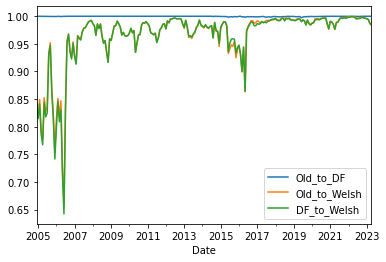

In [45]:
### TESTING: RESDULTS COMPARISION

df_corr_to_compare = df_res_to_compare.groupby('Date').corr()
df_corr_pairs = df_corr_to_compare.loc[(All, 'Old_Style'), ['DF_Style', 'DF_Welsh']].droplevel(-1)
df_corr_pairs.columns = ['Old_to_DF', 'Old_to_Welsh']
df_corr_pairs['DF_to_Welsh'] = df_corr_to_compare.loc[(All, 'DF_Style'), 'DF_Welsh'].droplevel(-1)
display(df_corr_pairs.describe())
df_corr_pairs.plot()